# Point Cloud Segmentation Demos

This notebook aims at preparing semantic segmentation demos. It will takes as input an entire floor and output the semantic segmented result.

## Import

In [1]:
import os.path
import sys
import numpy as np
from timeit import default_timer as timer
sys.path.append('partition/cut-pursuit/src')
sys.path.append('partition/ply_c')
sys.path.append('partition')
import libcp
import libply_c
from graphs import *
from provider import *
sys.path.append('./providers')
from datasets import *

import torch
import torch.nn as nn
from providers.datasets import HelixDataset
from collections import defaultdict
import h5py
import os
from plyfile import PlyData, PlyElement
import open3d as o3d

sys.path.append('learning')
sys.path.append('partition')
import spg
import graphnet
import pointnet
import metrics
import provider
import s3dis_dataset
import custom_dataset

from visualisation import display_cloud

import matplotlib
import matplotlib.pylab as plt
import time
import open3d

import math

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

/home/jovyan/my-conda-envs/superpoint/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 88 from C header, got 96 from PyObject
  return f(*args, **kwds)


## Code Helper

In [2]:
def plot_2d(clouds,axis_range=None,size = 100000,savefile = None,display=True, show_axis = False, wall_list_x = [], wall_list_y=[], additional_signal=None):
    """
    Plots a point cloud in 2d (in the x,y plane)
    You can use this function to generate images from the cloud and save to disk directly
    """
    try:
        #Init figure
        x_size = 20
        if axis_range:
            ratio = (axis_range[1] - axis_range[0])/(axis_range[3] - axis_range[2])
        else:
            ratio = 1
        fig = plt.figure(figsize=(x_size,x_size / ratio))
        
        #Print clouds
        for cloud in clouds:
            cloud_arr = np.asarray(cloud.points)
            if size > cloud_arr.shape[0]:
                idx = np.random.randint(len(cloud_arr), size=size)
                cloud_arr_sub = cloud_arr[idx,:]
            else:
                cloud_arr_sub = cloud_arr
            color = np.random.rand(3)
            plt.plot(cloud_arr_sub[:,0],cloud_arr_sub[:,1],"o",markersize=0.2,color=color)
        if additional_signal:
            plt.plot(additional_signal[0],additional_signal[1])
        plt.axis("equal")
        if axis_range:
            plt.axis(axis_range)
            for wall in wall_list_x:
                plt.plot([wall,wall],[axis_range[2],axis_range[3]],'k-')
            for wall in wall_list_y:
                plt.plot([axis_range[0],axis_range[1]],[wall, wall],'k-')
        if not show_axis:
            plt.axis('off')
        if savefile:
            plt.savefig(savefile,dpi=150)
        if display:
            plt.show()
    except Exception as e:
        print(e)

def get_floorceiling(cloud,min_distance_floor_cieling = 2 ):
    bin_size = 0.05
    z_histogram = create_histogram(cloud,bin_size,2)
    
    # extracts floors and celing
    sorted_counts = np.sort(z_histogram[0])
    lcounts = list(z_histogram[0])
    floor = 1e6
    ceiling = -1e6
    for i in range(len(sorted_counts)):
        counts = sorted_counts[-(i+1)]
        index = lcounts.index(counts)
        zlevel = z_histogram[1][index]
        if zlevel < floor:
            floor = zlevel
        if zlevel > ceiling:
            ceiling = zlevel
        if (ceiling - floor) > min_distance_floor_cieling:
            return (floor,ceiling,z_histogram)
    return (floor,ceiling,z_histogram)

def create_histogram(o3dcloud, bin_size=0.1, axis =2):
    numpy_cloud = np.asarray(o3dcloud.points)
    hmin = np.min(numpy_cloud[:,axis])
    hmax = np.max(numpy_cloud[:,axis])
    nb_bins = int(abs(hmax - hmin) / bin_size)
    return np.histogram(numpy_cloud[:,axis],bins = np.linspace(hmin,hmax,nb_bins))

## Point Cloud Semantic Segmentation Class

In [19]:
class PointCloudSegmentation(object):
    """
    Collection of functions used to segment a point cloud
    """
    
    def __init__(self, MODEL_PATH, dataset):
        self._model_path = MODEL_PATH
        self._dataset = dataset
        self._model, self._cloud_embedder, self._args = self._load_model()
        
    
    def process(self, input_pcl, save_model = False):
        """ take a raw point cloud as input and output a segmented point cloud in a .ply file"""
        root, folder, file = self._partition(input_pcl)
        print("=================\n   "+ 'Running Inferences' +"\n=================")
        predictions = self._predict(root, folder, file)
        xyz, xyz_labels = self._save(root, folder+file , predictions, save_model)
        return xyz, xyz_labels
    
    
    def display(self, xyz, xyz_labels):
        n_labels = 14
        clouds = []
        labels = []
        colors = []
        
        if self._dataset == 's3dis':
            dataset_info = s3dis_dataset.get_info(self._args.edge_attribs,self._args.pc_attribs)
        elif self._dataset == 'helix':
            dataset_info = HelixDataset().get_info(self._args.edge_attribs,self._args.pc_attribs)
        
        for i_label in range(n_labels):
            cloud = xyz[np.where(xyz_labels == i_label)]
            # converting simple array to open3d.PointCloud object
            pcd = o3d.PointCloud()
            pcd.points = o3d.Vector3dVector(cloud)
            if len(pcd.points) != 0 :
                clouds.append(pcd)
                labels.append(dataset_info['inv_class_map'][i_label+1])
                colors.append(provider.get_color_from_label(i_label+1, self._dataset))
        
        colors = np.asarray(colors)/255
        display_cloud(clouds = clouds, labels = labels, colors = colors)
       
    
    def _load_model(self):
        """ load the weiths of the model """
        print("=================\n   "+ 'Preparing Model' +"\n=================")
        print("=> loading checkpoint '{}'".format(self._model_path))
        checkpoint = torch.load(self._model_path)
        checkpoint['args'].resume = self._model_path
        print(checkpoint['args'])
        cloud_embedder = pointnet.CloudEmbedder(checkpoint['args'])
        dbinfo = HelixDataset().get_info(checkpoint['args'].edge_attribs,checkpoint['args'].pc_attribs)
        model = self._create_model(checkpoint['args'], dbinfo) #use original arguments, architecture can't change    
        model.load_state_dict(checkpoint['state_dict'])
        return model, cloud_embedder, checkpoint['args']
    
    
    def load_prediction(self, root_path, filename, prediction_file):
        """ load the predictions from a file
        root_path : relative path to the data folder (containing features, superpoint graph... folders)
        filename : filename without the extension and its parent directory. ex : if test_01.ply in in directory test : test\test_01
        prediction_file : name of the prediction file : ex test_01_predictions.h5
        """
        n_labels = 14

        folder = os.path.split(filename)[0] + '/'
        file_name = os.path.split(filename)[1]

        #---load the values------------------------------------------------------------
        fea_file   = os.path.join(root_path,'features',folder,file_name + '.h5')
        spg_file   = os.path.join(root_path,'superpoint_graphs',folder,file_name + '.h5')
        ply_folder = os.path.join(root_path,'clouds',folder)
        #pred_folder = os.path.join(root_path,'predictions',folder)
        ply_file   = os.path.join(ply_folder,file_name)
        res_file   = os.path.join(root_path,'predictions', folder, prediction_file)

        if not os.path.isdir(ply_folder ):
            os.mkdir(ply_folder)
        if (not os.path.isfile(fea_file)) :
            raise ValueError("%s does not exist and is needed" % fea_file)

        geof, xyz, rgb, graph_nn, labels = provider.read_features(fea_file)

        if not os.path.isfile(spg_file):    
            raise ValueError("%s does not exist and is needed to output the partition  or result ply" % spg_file) 
        else:
            graph_spg, components, in_component = provider.read_spg(spg_file)

        if not os.path.isfile(res_file):
            raise ValueError("%s does not exist and is needed." % res_file) 
        try:
            pred_red  = np.array(h5py.File(res_file, 'r').get(folder + file_name))        
            if (len(pred_red) != len(components)):
                raise ValueError("It looks like the spg is not adapted to the result file") 
            pred_full = provider.reduced_labels2full(pred_red, components, len(xyz))
        except OSError:
            raise ValueError("%s does not exist in %s" % (folder + file_name, res_file))
        
        return xyz, pred_full
        
        
    def _create_model(self, args, dbinfo):
        """ Creates the model """
        model = nn.Module()
        nfeat = args.ptn_widths[1][-1]
        model.ecc = graphnet.GraphNetwork(args.model_config, nfeat, [dbinfo['edge_feats']] + args.fnet_widths, args.fnet_orthoinit, args.fnet_llbias,args.fnet_bnidx, args.edge_mem_limit)
        model.ptn = pointnet.PointNet(args.ptn_widths[0], args.ptn_widths[1], args.ptn_widths_stn[0], args.ptn_widths_stn[1], dbinfo['node_feats'], args.ptn_nfeat_stn, prelast_do=args.ptn_prelast_do)
        print('Total number of parameters: {}'.format(sum([p.numel() for p in model.parameters()]))) 
        if args.cuda: 
            model.cuda()
        return model 
    
    
    def _partition(self, path_to_pcl, k_nn_geof = 45, k_nn_adj = 10, lambda_edge_weight = 1., reg_strength = 0.03, d_se_max = 0, voxel_width = 0.03, ver_batch = 0, overwrite = 0 ):
            """ Large-scale Point Cloud Segmentation with Superpoint Graphs
            Input : - path_to_pcl : path to the raw point cloud .ply file.
                    - k_nn_geof : number of neighbors for the geometric features, type=int
                    - k_nn_adj : adjacency structure for the minimal partition, type=int
                    - lambda_edge_weight : parameter determine the edge weight for minimal part, type=float
                    - reg_strength : regularization strength for the minimal partition, type=float
                    - d_se_max : max length of super edges, type=float
                    - voxel_width : voxel size when subsampling (in m), type=float
                    - ver_batch : Batch size for reading large files, 0 do disable batch loading, type=int
                    - overwrite : Wether to read existing files or overwrite them, type=int
            """
            
            if self._dataset == 's3dis':
                root, file =  os.path.dirname(os.path.dirname(os.path.dirname(os.path.split(os.path.abspath(path_to_pcl))[0]))), os.path.split(os.path.abspath(path_to_pcl))[1]
                root = root + '/'
            elif self._dataset == 'helix':
                root, file =  os.path.dirname(os.path.dirname(os.path.split(os.path.abspath(path_to_pcl))[0])), os.path.split(os.path.abspath(path_to_pcl))[1]
                root = root + '/'
            
            #list of subfolders to be processed
            if self._dataset == 's3dis':
                folder = os.path.split(os.path.dirname(os.path.dirname(path_to_pcl)))[1] + '/'
                n_labels = 13
            elif self._dataset == 'helix':
                helix_data = HelixDataset()
                folder = os.path.split(os.path.split(os.path.abspath(path_to_pcl))[0])[1] + '/'
                n_labels = len(helix_data.labels.keys())
            else:
                raise ValueError('%s is an unknown data set' % dataset)

            times = [0,0,0] #time for computing: features / partition / spg

            if not os.path.isdir(root + "clouds"):
                os.mkdir(root + "clouds")
            if not os.path.isdir(root + "features"):
                os.mkdir(root + "features")
            if not os.path.isdir(root + "superpoint_graphs"):
                os.mkdir(root + "superpoint_graphs")

            print("=================\n   "+ 'Start Partitioning {}'.format(file)+"\n=================")
            
            data_folder = root   + "data/"              + folder
            cloud_folder  = root + "clouds/"            + folder
            fea_folder  = root   + "features/"          + folder
            spg_folder  = root   + "superpoint_graphs/" + folder
            if not os.path.isdir(data_folder):
                raise ValueError("%s does not exist" % data_folder)

            if not os.path.isdir(cloud_folder):
                os.mkdir(cloud_folder)
            if not os.path.isdir(fea_folder):
                os.mkdir(fea_folder)
            if not os.path.isdir(spg_folder):
                os.mkdir(spg_folder)
            
            file_name = os.path.splitext(os.path.basename(file))[0]
           
            if self._dataset == 's3dis':
                if not os.path.isfile(data_folder +  file_name + '/' + file):
                    raise ValueError('{} does not exist in {}'.format(file, data_folder +  file_name + '/'))
            elif self._dataset == 'helix':
                if not os.path.isfile(data_folder +  file):
                    raise ValueError('{} does not exist in {}'.format(file, data_folder))
            
            if self._dataset =='s3dis':
                data_file   = data_folder      + file_name + '/' + file_name + ".txt"
                cloud_file  = cloud_folder     + file_name
                fea_file    = fea_folder       + file_name + '.h5'
                spg_file    = spg_folder       + file_name + '.h5'
            elif self._dataset =='helix':
                data_file   = data_folder      + file_name + helix_data.extension
                cloud_file  = cloud_folder     + file_name
                fea_file    = fea_folder       + file_name + '.h5'
                spg_file    = spg_folder       + file_name + '.h5'

            #--- build the geometric feature file h5 file ---
            if os.path.isfile(fea_file) and not overwrite:
                print("    reading the existing feature file...")
                geof, xyz, rgb, graph_nn, labels = read_features(fea_file)
            else :
                print("    creating the feature file...")
                #--- read the data files and compute the labels---
                
                if self._dataset ==' s3dis':
                    xyz, rgb, labels = read_s3dis_format(data_file)
                    if voxel_width > 0:
                        xyz, rgb, labels = libply_c.prune(xyz, voxel_width, rgb, labels, n_labels)
                elif self._dataset == 'helix' :
                    xyz = helix_data.read_pointcloud(data_file).astype(dtype='float32')
                    if voxel_width > 0:
                        xyz = libply_c.prune(xyz, voxel_width, np.zeros(xyz.shape,dtype='u1'), np.array(1,dtype='u1'), 0)[0]
                    labels = []
                    rgb = []

                start = timer()
                #---compute 10 nn graph-------
                graph_nn, target_fea = compute_graph_nn_2(xyz, k_nn_adj, k_nn_geof)
                #---compute geometric features-------
                geof = libply_c.compute_geof(xyz, target_fea, k_nn_geof).astype('float32')
                end = timer()
                times[0] = times[0] + end - start
                del target_fea
                write_features(fea_file, geof, xyz, rgb, graph_nn, labels)
            #--compute the partition------
            sys.stdout.flush()
            if os.path.isfile(spg_file) and not overwrite:
                print("    reading the existing superpoint graph file...")
                graph_sp, components, in_component = read_spg(spg_file)
            else:
                print("    computing the superpoint graph...")
                #--- build the spg h5 file --
                features = geof
                geof[:,3] = 2. * geof[:, 3]
                if self._dataset =='s3dis':
                    features = np.hstack((geof, rgb/255.)).astype('float32')#add rgb as a feature for partitioning
                    features[:,3] = 2. * features[:,3] #increase importance of verticality (heuristic)
                elif self._dataset =='helix':
                    features = geof
                    features[:,3] = 2. * features[:, 3]

                graph_nn["edge_weight"] = np.array(1. / (lambda_edge_weight + graph_nn["distances"] / np.mean(graph_nn["distances"])), dtype = 'float32')
                print("        minimal partition...")
                components, in_component = libcp.cutpursuit(features, graph_nn["source"], graph_nn["target"]
                                             , graph_nn["edge_weight"], reg_strength)
                components = np.array(components, dtype = 'object')
                end = timer()
                times[1] = times[1] + end - start
                print("        computation of the SPG...")
                start = timer()
                graph_sp = compute_sp_graph(xyz, d_se_max, in_component, components, labels, n_labels)
                end = timer()
                times[2] = times[2] + end - start
                write_spg(spg_file, graph_sp, components, in_component)
            print("Timer : %5.1f / %5.1f / %5.1f " % (times[0], times[1], times[2]))
            return root[:-1], folder, file_name
    
    def _predict(self, root, folder, file):
        self._args.ROOT_PATH = root
        # this points toward the training data used so it can 'normalize' the edges features of the tested data wrt the training set
        # comment out and specify if you changed the named of the folder used for training
        #self._args.S3DIS_PATH = 'data/custom_S3DIS_bis'
        
        file_name = file+'.h5'
        if self._dataset == 's3dis':
            create_dataset = s3dis_dataset.get_datasets
        elif self._dataset == 'helix':
            HelixDataset().preprocess_pointclouds(self._args.ROOT_PATH, self._args.pc_attribs, single_file = True, filename = file_name, folder = folder)
            create_data = HelixDataset().get_data_for_inference_only
        
        if not os.path.isdir(root + "/predictions"):
                os.mkdir(root + "/predictions")
        pred_folder = root   + "/predictions/" + folder
        if not os.path.isdir(pred_folder):
                os.mkdir(pred_folder)
            
        collected = defaultdict(list)
        eval_data = create_data(self._args, filename = file_name, folder_s = folder)[1]
        loader = torch.utils.data.DataLoader(eval_data, batch_size=1, collate_fn=spg.eccpc_collate, num_workers=8)
        for bidx, (targets, GIs, clouds_data) in enumerate(loader):
            self._model.ecc.set_info(GIs, self._args.cuda)
            label_mode_cpu, label_vec_cpu, segm_size_cpu = targets[:,0], targets[:,2:], targets[:,1:].sum(1).float()
            data = clouds_data
            embeddings = self._cloud_embedder.run(self._model, *clouds_data)
            outputs = self._model.ecc(embeddings)
            fname = clouds_data[0][0][:clouds_data[0][0].rfind('.')]
            collected[fname].append((outputs.data.cpu().numpy(), label_mode_cpu.numpy(), label_vec_cpu.numpy()))
        predictions = {}
        with h5py.File(os.path.join(pred_folder, os.path.splitext(os.path.basename(file))[0] +'_predictions.h5'), 'w') as hf:
            for fname,output in collected.items():
                o_cpu, t_cpu, tvec_cpu = list(zip(*output))
                o_cpu = np.mean(np.stack(o_cpu,0),0)
                prediction = np.argmax(o_cpu,axis=-1)
                predictions[fname] = prediction
                hf.create_dataset(name=fname, data=prediction) #(0-based classes)
        return predictions  
    
    
    def _save(self, root_path, filename,predictions, save_model):
        n_labels = 14

        folder = os.path.split(filename)[0] + '/'
        file_name = os.path.split(filename)[1]

        #---load the values------------------------------------------------------------
        fea_file   = os.path.join(root_path,'features',folder,file_name + '.h5')
        spg_file   = os.path.join(root_path,'superpoint_graphs',folder,file_name + '.h5')
        ply_folder = os.path.join(root_path,'clouds',folder)
        ply_file   = os.path.join(ply_folder,file_name)

        if not os.path.isdir(ply_folder ):
            os.mkdir(ply_folder)
        if (not os.path.isfile(fea_file)) :
            raise ValueError("%s does not exist and is needed" % fea_file)

        geof, xyz, rgb, graph_nn, labels = provider.read_features(fea_file)

        if not os.path.isfile(spg_file):    
            raise ValueError("%s does not exist and is needed to output the partition  or result ply" % spg_file) 
        else:
            graph_spg, components, in_component = provider.read_spg(spg_file)
        
        pred_red  = predictions[filename]        
        if (len(pred_red) != len(components)):
            raise ValueError("It looks like the spg is not adapted to the result file") 
        pred_full = provider.reduced_labels2full(pred_red, components, len(xyz))
        
        if save_model:
            print("=================\n   "+ 'Saving Segmented Point Cloud' +"\n=================")
            print("writing the prediction file (i.e Semantic Segmented Point Cloud) in {}...".format(ply_folder))
            provider.prediction2ply(ply_file + "_pred.ply", xyz, pred_full, n_labels,  self._dataset)
        
        return xyz, pred_full

# Semantic Segmentation

## Load Cloud and split it

Floor level = 9.61223063468933
Celing level = 12.242390432357787


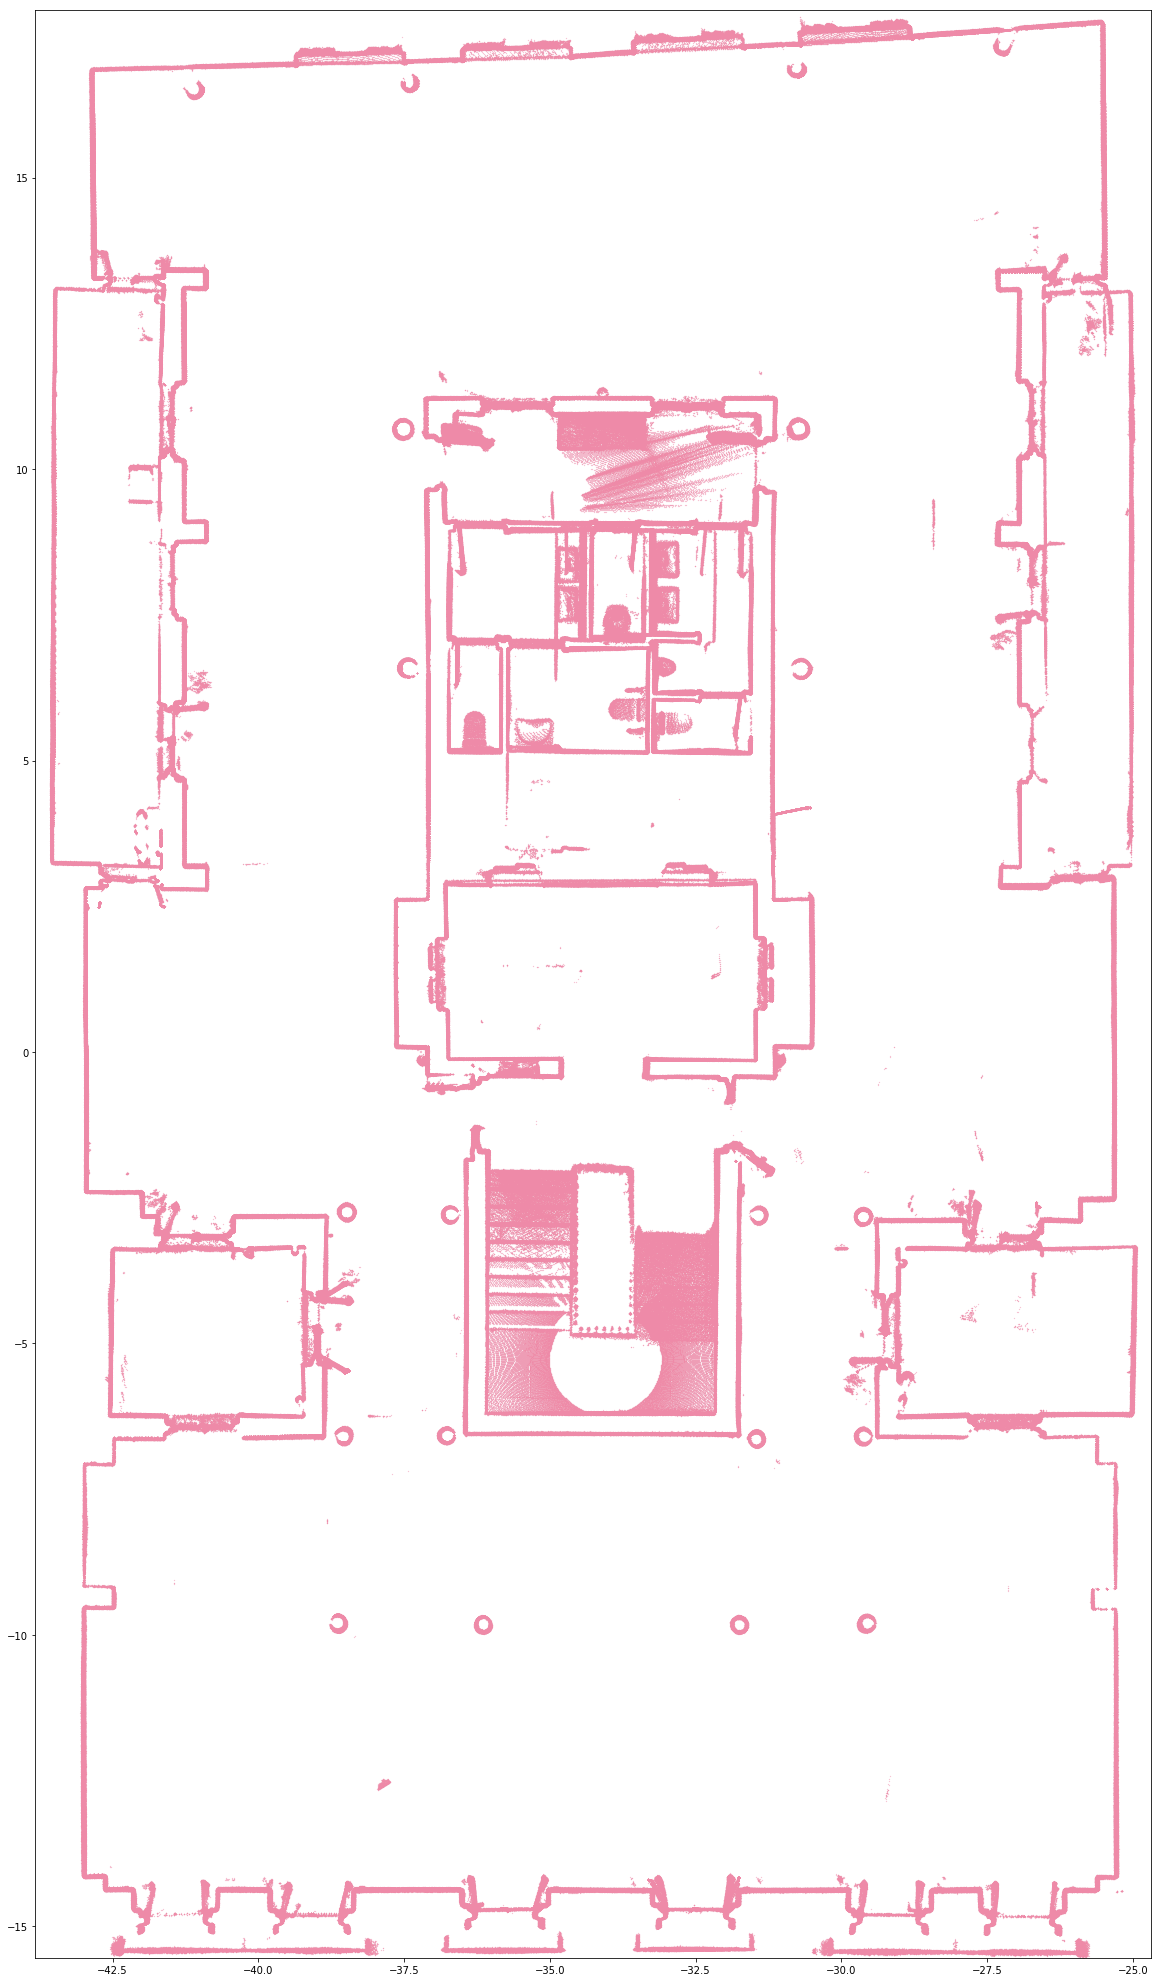

In [4]:
#INPUT_FILE = 'data/BUND/data/Floor_4/Floor_4_sub.ply'
INPUT_FILE = 'data/weWork/data/floor_3/Floor_03.ply' 
cloud = open3d.read_point_cloud(INPUT_FILE) # add format='xyz' when reading from .txt files 
#small_cloud = open3d.voxel_down_sample(cloud, voxel_size = 0.03)
(floor,ceiling,z_histogram) = get_floorceiling(cloud)
print("Floor level = " + str(floor))
print("Celing level = " + str(ceiling))

minbox = cloud.get_min_bound()
maxbox = cloud.get_max_bound()
ROOF_CEILING_PADDING = (ceiling - floor)*0.1
new_cloud = open3d.crop_point_cloud(cloud,[minbox[0],minbox[1],floor + ROOF_CEILING_PADDING],[maxbox[0],maxbox[1],ceiling - ROOF_CEILING_PADDING])
plot_2d([new_cloud],size = -1,axis_range=[minbox[0],maxbox[0],minbox[1],maxbox[1]],show_axis=True)

In [5]:
xmin = minbox[0]
ymin = minbox[1]
xmax = maxbox[0]
ymax = maxbox[1]

w = math.ceil((xmax-xmin)/7)
h = math.ceil((ymax-ymin)/7)
print(' width : {} ; height : {}'.format(w,h))

 width : 3 ; height : 5


In [6]:
files = {}
for y in range(1,h+1):
    for x in range(1,w+1):
        files['{}_{}'.format(y,x)]=  'data/weWork/data/floor_3/crop_{}_{}.ply'.format(y,x)

In [7]:
min_boxes = {}
for y in range(1,h+1):
    for x in range(1,w+1):
        filename = files['{}_{}'.format(y,x)]
        cloud = open3d.read_point_cloud(filename)
        minbox = cloud.get_min_bound()
        min_boxes['{}_{}'.format(y,x)] = minbox

In [14]:
points = np.asarray(cloud.points)

rooms = {}
for y in range(1,h+1):
    for x in range(1,w+1):
        rooms['{}_{}'.format(y,x)]=  []

for pts in points :
    x,y,z = pts[0], pts[1], pts[2]
    if y-ymin <= 0 :
        row = 1
    else :
        row = math.ceil((y-ymin)/7)
    if x-xmin <= 0 :
        col = 1
    else :
        col = math.ceil((x-xmin)/7)

    room = rooms['{}_{}'.format(row, col)]
    room.append(pts)

for y in range(1,h+1):
    for x in range(1,w+1):
        rooms['{}_{}'.format(y,x)] = np.stack(rooms['{}_{}'.format(y,x)])

In [15]:
for y in range(1,h+1):
    for x in range(1,w+1):
        pcd = open3d.PointCloud()
        pcd.points = open3d.Vector3dVector(rooms['{}_{}'.format(y,x)])
        open3d.write_point_cloud(files['outfile_{}_{}'.format(y,x)], pcd)


## Run Segmentation and Inferences

In [20]:
MODEL_PATH = 'results/helix/bw/cv1/model.pth.tar'
dataset = 'helix'
model = PointCloudSegmentation(MODEL_PATH, dataset)

   Preparing Model
=> loading checkpoint 'results/helix/bw/cv1/model.pth.tar'
Namespace(CUSTOM_SET_PATH='datasets/custom_set', S3DIS_PATH='data/custom_helix', SEMA3D_PATH='datasets/semantic3d', batch_size=2, cuda=1, cvfold=1, dataset='helix', db_test_name='val', db_train_name='train', edge_attribs='delta_avg,delta_std,nlength/ld,surface/ld,volume/ld,size/ld,xyz/d', edge_mem_limit=30000, epochs=150, fnet_bnidx=2, fnet_llbias=0, fnet_orthoinit=1, fnet_widths=[32, 128, 64], grad_clip=1, lr=0.01, lr_decay=0.7, lr_steps=[275, 320], model_config='gru_10_0,f_12', momentum=0.9, nworkers=8, odir='results/helix/bw/cv1', optim='adam', pc_attribs='xyzelpsv', pc_augm_jitter=1, pc_augm_mirror_prob=0, pc_augm_rot=1, pc_augm_scale=0, pc_xyznormalize=1, ptn_mem_monger=1, ptn_minpts=40, ptn_nfeat_stn=8, ptn_npts=128, ptn_prelast_do=0, ptn_widths=[[64, 64, 128, 128, 256], [256, 64, 32]], ptn_widths_stn=[[64, 64, 128], [128, 64]], resume='results/helix/bw/cv1/model.pth.tar', save_nth_epoch=1, seed=1, spg_

In [11]:
# Putting everything back togeter
XYZ = []
XYZ_labels = []

xyz = {}
xyz_labels = {}

for y in range(1,h+1):
    for x in range(1,w+1):
        xyz['{}_{}'.format(y,x)], xyz_labels['{}_{}'.format(y,x)]=  model.process('data/weWork/data/floor_3/crop_{}_{}.ply'.format(y,x), save_model = False)
        
        xyz['{}_{}'.format(y,x)][:,0] += min_boxes['{}_{}'.format(y,x)][0]
        xyz['{}_{}'.format(y,x)][:,1] += min_boxes['{}_{}'.format(y,x)][1]
        xyz['{}_{}'.format(y,x)][:,2] += min_boxes['{}_{}'.format(y,x)][2]
        
        XYZ.append(xyz['{}_{}'.format(y,x)])
        XYZ_labels.append(xyz_labels['{}_{}'.format(y,x)])
    
# converting a list of list into a list then from a list to an array
XYZ = np.asarray([item for sublist in XYZ for item in sublist])
XYZ_labels = np.asarray([item for sublist in XYZ_labels for item in sublist])

   Start Partitioning crop_1_1.ply
    reading the existing feature file...
    reading the existing superpoint graph file...
Timer :   0.0 /   0.0 /   0.0 
   Running Inferences
crop_1_1.h5
   Start Partitioning crop_1_2.ply
    reading the existing feature file...
    reading the existing superpoint graph file...
Timer :   0.0 /   0.0 /   0.0 
   Running Inferences
crop_1_2.h5
   Start Partitioning crop_1_3.ply
    reading the existing feature file...
    reading the existing superpoint graph file...
Timer :   0.0 /   0.0 /   0.0 
   Running Inferences
crop_1_3.h5
   Start Partitioning crop_2_1.ply
    reading the existing feature file...
    reading the existing superpoint graph file...
Timer :   0.0 /   0.0 /   0.0 
   Running Inferences
crop_2_1.h5
   Start Partitioning crop_2_2.ply
    reading the existing feature file...
    reading the existing superpoint graph file...
Timer :   0.0 /   0.0 /   0.0 
   Running Inferences
crop_2_2.h5
   Start Partitioning crop_2_3.ply
    readin

In [13]:
XYZ = []
XYZ_labels = []

xyz = {}
xyz_labels = {}

for y in range(1,5+1):
    for x in range(1,3+1):
        xyz['{}_{}'.format(y,x)], xyz_labels['{}_{}'.format(y,x)]= model.load_prediction('data/weWork', 'floor_3/crop_{}_{}'.format(y,x), 'crop_{}_{}_predictions.h5'.format(y,x))
        
        xyz['{}_{}'.format(y,x)][:,0] += min_boxes['{}_{}'.format(y,x)][0]
        xyz['{}_{}'.format(y,x)][:,1] += min_boxes['{}_{}'.format(y,x)][1]
        xyz['{}_{}'.format(y,x)][:,2] += min_boxes['{}_{}'.format(y,x)][2]
        
        XYZ.append(xyz['{}_{}'.format(y,x)])
        XYZ_labels.append(xyz_labels['{}_{}'.format(y,x)])
    
# converting a list of list into a list then from a list to an array
XYZ = np.asarray([item for sublist in XYZ for item in sublist])
XYZ_labels = np.asarray([item for sublist in XYZ_labels for item in sublist])



In [21]:
model.display(XYZ, XYZ_labels)

launching server
server launched, go to https://jupyterhub.helix.re/user/thomas/proxy/3221/cloud_viewer.html


In [18]:
provider.prediction2ply("full_floor_pred.ply", XYZ, XYZ_labels, 14,  'helix')

In [53]:
classes = ['ceiling', 'floor', 'wall', 'window', 'door', 'clutter']
label = [0, 1, 2, 5, 6, 12]
for i in range(len(label)):
    provider.prediction2ply("{}_pred.ply".format(classes[i]), XYZ[XYZ_labels == label[i]], XYZ_labels[XYZ_labels == label[i]], 14,  'helix')